2. 加载第 4 章中的葡萄酒数据集，并使用适当数量的输入参数创建一个新模型。
    - 与我们使用的温度数据相比，需要多长时间来训练？
    - 你能解释一下影响训练时间的因素吗？
    - 在对这个数据集进行训练时，你能减小损失吗？
    - 你将如何绘制此数据集的图形？

In [48]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import csv

torch.set_printoptions(edgeitems=2, linewidth=75)

In [49]:
# 加载数据集
wine_path = '../data/p1ch4/tabular-wine/winequality-white.csv'
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)

wineq = torch.from_numpy(wineq_numpy) # 继续将 NumPy 数组转换为 PyTorch 张量。

# 数据预处理
tsd = wineq[:, 6].unsqueeze(1) # 选择二氧化硫总量为输入参数，并扩充一个维度
quality = wineq[:, -1].unsqueeze(1) # 选择红酒质量为输出参数，并扩充一个维度
tsd.shape, quality.shape

(torch.Size([4898, 1]), torch.Size([4898, 1]))

In [50]:
# 划分训练数据集与测试数据集
n_samples = tsd.shape[0] # 样本总数
n_val = int(0.2 * n_samples) # 测试样本数量

# 生成一个随机的排列索引
"""  
n_samples 是一个整数，表示要生成的随机排列的长度
函数 torch.randperm(n_samples) 会返回一个长度为 n_samples 的一维张量，其中包含了从 0 到 n_samples-1 的随机排列。
"""
shuffled_indices = torch.randperm(n_samples)

# 分割出训练和测试数据集的索引
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices.shape, val_indices.shape

(torch.Size([3919]), torch.Size([979]))

In [51]:
# 训练数据集的输入与输出
tsd_train = tsd[train_indices]
quality_train = quality[train_indices]

# 测试数据集的输入与输出
tsd_val = tsd[val_indices]
quality_val = quality[val_indices]

tsd_train.shape, quality_train.shape, tsd_val.shape, quality_val.shape

(torch.Size([3919, 1]),
 torch.Size([3919, 1]),
 torch.Size([979, 1]),
 torch.Size([979, 1]))

In [52]:
# 定义模型
seq_model = nn.Sequential(
            nn.Linear(1, 11),
            nn.ReLU(),
            nn.Linear(11, 1))

In [53]:
# 定义优化器
optimizer = optim.Adam(seq_model.parameters(), lr=1e-2)

# 定义训练函数
def training_loop(n_epochs, optimizer, model, loss_fn, tsd_train, tsd_val, quality_train, quality_val):
    # 用于存储训练损失和验证损失的列表
    loss_train_list = []
    loss_val_list = []

    for epoch in range(1, n_epochs+1):
        q_p_train = model(tsd_train)
        loss_train = loss_fn(q_p_train, quality_train)
        loss_train_list.append(loss_train.detach().numpy())

        q_p_val = model(tsd_val)
        loss_val = loss_fn(q_p_val, quality_val)
        loss_val_list.append(loss_val.detach().numpy())

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
                print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                    f" Validation loss {loss_val.item():.4f}")
    
    return loss_train_list, loss_val_list, q_p_val

In [54]:
# 开始训练
loss_train_list, loss_val_list, q_p_val = training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    tsd_train=tsd_train,
    tsd_val=tsd_val,
    quality_train=quality_train,
    quality_val=quality_val
)
# len(loss_train_list),len(loss_val_list),q_p_val.shape


Epoch 1, Training loss 455.2648, Validation loss 463.3574
Epoch 1000, Training loss 0.9358, Validation loss 0.8928
Epoch 2000, Training loss 0.7642, Validation loss 0.7449
Epoch 3000, Training loss 0.7642, Validation loss 0.7449
Epoch 4000, Training loss 0.7662, Validation loss 0.7447
Epoch 5000, Training loss 0.7642, Validation loss 0.7449


Text(0, 0.5, '损失')

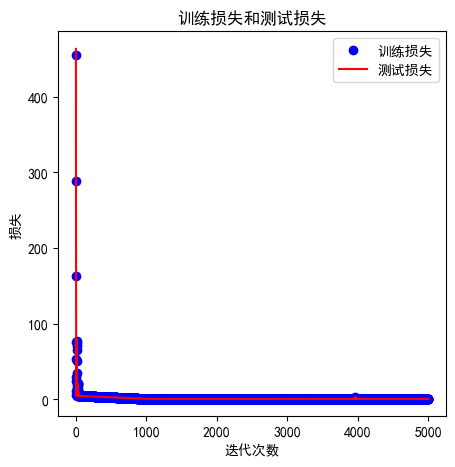

In [55]:
# 数据可视化
from matplotlib import pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False

fig = plt.figure(figsize=(5,5))
# 训练损失与测试损失的可视化
epochs = range(1, len(loss_train_list) + 1)
plt.plot(epochs, loss_train_list, 'bo', label='训练损失')
plt.plot(epochs, loss_val_list, 'r', label='测试损失')
plt.title('训练损失和测试损失')
plt.xlabel("迭代次数")
plt.legend()
plt.ylabel("损失")


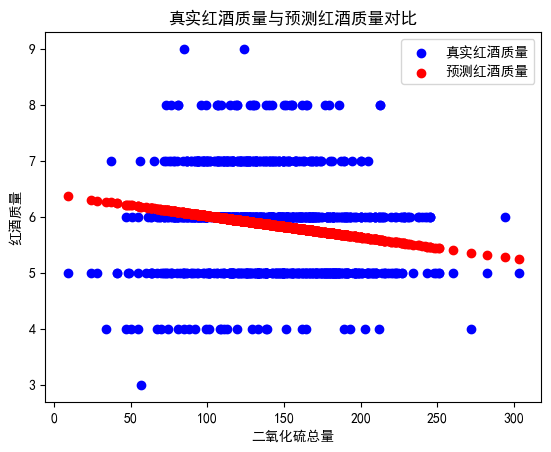

In [56]:
plt.scatter(tsd_val, quality_val.detach().numpy(),  c='blue', label='真实红酒质量')
plt.scatter(tsd_val, q_p_val.detach().numpy(), c='red', label='预测红酒质量')
plt.title('真实红酒质量与预测红酒质量对比')
plt.xlabel('二氧化硫总量')
plt.ylabel('红酒质量')
plt.legend()

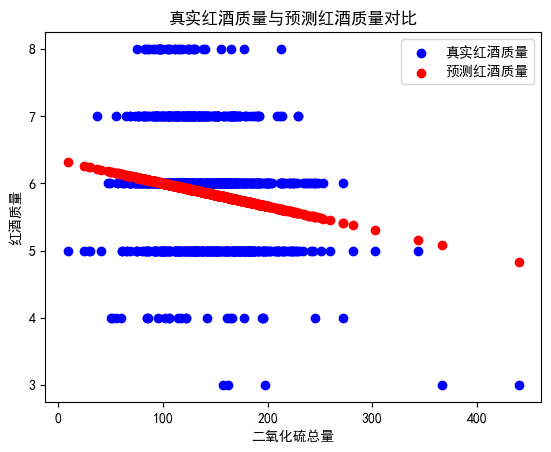

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
data = pd.read_csv(wine_path)
X = tsd
y = quality
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.scatter(X_test, y_test, color='blue', label='真实红酒质量')
plt.scatter(X_test, y_pred, color='red', label='预测红酒质量')
plt.title('真实红酒质量与预测红酒质量对比')
plt.xlabel('二氧化硫总量')
plt.ylabel('红酒质量')
plt.legend()

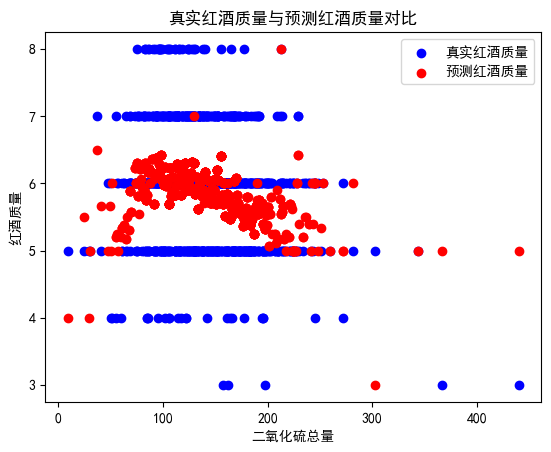

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
data = pd.read_csv(wine_path)
X = tsd
y = quality
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = RandomForestRegressor()
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

plt.scatter(X_test, y_test, color='blue', label='真实红酒质量')
plt.scatter(X_test, y_pred, color='red', label='预测红酒质量')
plt.title('真实红酒质量与预测红酒质量对比')
plt.xlabel('二氧化硫总量')
plt.ylabel('红酒质量')
plt.legend()